# Brier Score
Machine Learning with Imbalanced Data - Course

The Brier Score measures the fit of the probability estimates of the observed data. It is given by the average squared difference of the true label and the predicted probability.

$$Brier Score = mean( (y -pred)^2 )$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score, RocCurveDisplay

from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

## Function to create toy data

In [2]:
def create_dataset(weights):

    # returns arrays
    X, y = make_classification(
        n_samples=10000,
        n_features=20,
        n_informative=2,
        n_redundant=10,
        n_clusters_per_class=1,
        weights=[weights],  # to balance (or not) the classes
        class_sep=1,  # how separated the classes are
        random_state=1)

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X)
    y = pd.Series(y)

    return X, y

## Balanced dataset

In [3]:
X, y = create_dataset(weights=0.5)

# show dataset
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.367744,0.169118,0.490309,-0.099269,-0.321689,2.028729,-1.217080,1.052782,-0.219787,-0.532625,-0.284029,0.748649,-1.609348,-0.604958,-0.562323,0.781532,0.972701,1.099992,0.386859,0.932917
1,-0.992571,1.453483,1.240380,-0.258057,-0.354514,-0.936577,0.813220,1.180121,0.123450,-1.598957,-1.581506,1.981644,0.457818,0.116732,-1.117829,-0.350214,1.469932,1.829999,-0.422171,-0.895785
2,0.777302,1.651992,1.284101,-1.147468,-0.541526,-0.648523,-0.506134,1.008741,-0.006846,-1.691435,-1.761168,2.064089,-0.597753,0.357367,-1.113473,-0.696747,1.379473,1.757694,-0.638204,-0.524468
3,0.503518,-0.010875,0.213944,0.064097,0.823696,-0.104237,-0.844305,0.581817,0.907700,-0.211645,-0.052696,0.319429,-1.281878,-0.399945,-0.270524,0.533142,0.506226,0.558628,0.284446,-2.104917
4,0.030649,-0.176175,-0.067561,-0.116144,-1.406837,-0.660697,-0.093624,0.076004,-0.876487,0.110881,0.167762,-0.116232,-0.303181,-0.162147,0.032064,0.239197,0.013647,-0.009563,0.155488,0.685216


In [4]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 20), (3000, 20))

In [8]:
# setup models
logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)

bayes = GaussianNB().fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=0,
).fit(X_train, y_train)

gm = GradientBoostingClassifier(
    n_estimators=10,
    random_state=0,
).fit(X_train, y_train)

In [10]:
# roc-auc
for model in [logit, bayes, rf, gm]:
    probs = model.predict_proba(X_test)[:, 1]
    print(f'roc-auc of {type(model).__name__}: {roc_auc_score(y_test, probs):.4f}')

roc-auc of LogisticRegression: 0.9505
roc-auc of GaussianNB: 0.9369
roc-auc of RandomForestClassifier: 0.9476
roc-auc of GradientBoostingClassifier: 0.9602


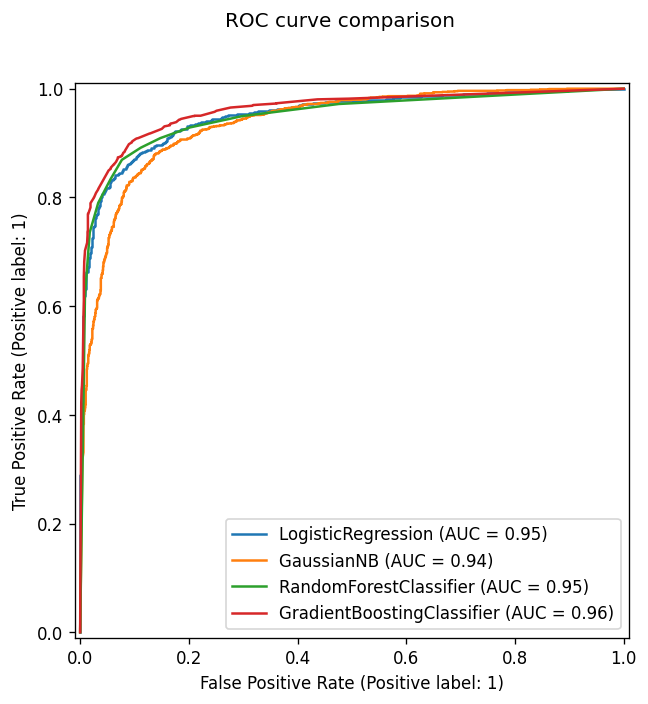

In [11]:
plt.figure(figsize=(8, 6), dpi=120)
ax = plt.gca()

for model in [logit, bayes, rf, gm]:
    
    # plot ROC curve
    tmp_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)

tmp_disp.figure_.suptitle("ROC curve comparison")
plt.show()

In [12]:
## Brier scores

for model in [logit, bayes, rf, gm]:
    probs = model.predict_proba(X_test)[:, 1]
    print(f'Brier score of {type(model).__name__}: {brier_score_loss(y_test, probs):.4f}')

Brier score of LogisticRegression: 0.0838
Brier score of GaussianNB: 0.1211
Brier score of RandomForestClassifier: 0.0820
Brier score of GradientBoostingClassifier: 0.0955


From the Brier Score, we see that even though Gradient Boosting Machines show the highest performance, it Brier Score is bigger, suggesting that its probabilities are not as well calibrated as those from Random Forest and Logistic Regression.

In [13]:
# calibration curve
def plot_calibration_curve(bins):

    plt.figure(figsize=(10, 8))

    for model in [logit, bayes, rf, gm]:

        # obtain predictions
        probs = model.predict_proba(X_test)[:, 1]

        # obtain calibration curve parameters
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, probs, n_bins=bins, strategy='uniform')

        plt.plot(mean_predicted_value, fraction_of_positives,
                 label=type(model).__name__)

    # add perfectly calibrated predictions
    plt.plot(np.linspace(0, 1, bins), np.linspace(0, 1, bins),
             linestyle='--', color='red', label='Perfect calibration')

    # add labels
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')

    # show
    plt.show()

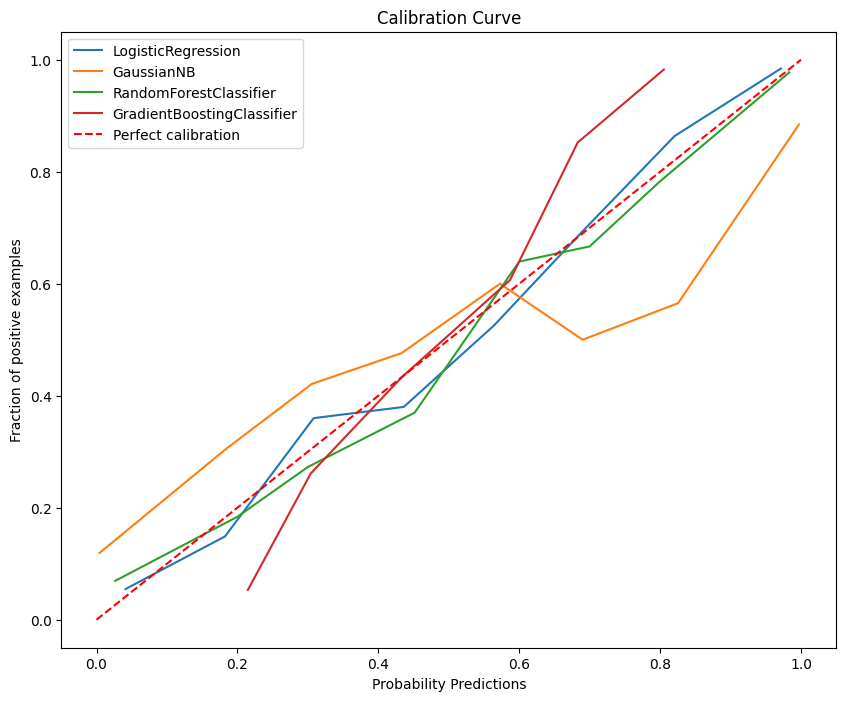

In [14]:
plot_calibration_curve(bins=8)

As expected, Naive Bayes and Gradient Boosting Machines show the worse calibration.

## Imbalanced dataset

In [15]:
X, y = create_dataset(weights=0.9)

# show dataset
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.367744,0.169118,0.490309,-0.099269,-0.321689,2.028729,-1.217080,1.052782,-0.219787,-0.532625,-0.284029,0.748649,-1.609348,-0.604958,-0.562323,0.781532,0.972701,1.099992,0.386859,0.932917
1,-0.992571,1.453483,1.240380,-0.258057,-0.354514,-0.936577,0.813220,1.180121,0.123450,-1.598957,-1.581506,1.981644,0.457818,0.116732,-1.117829,-0.350214,1.469932,1.829999,-0.422171,-0.895785
2,0.777302,1.651992,1.284101,-1.147468,-0.541526,-0.648523,-0.506134,1.008741,-0.006846,-1.691435,-1.761168,2.064089,-0.597753,0.357367,-1.113473,-0.696747,1.379473,1.757694,-0.638204,-0.524468
3,0.503518,-0.010875,0.213944,0.064097,0.823696,-0.104237,-0.844305,0.581817,0.907700,-0.211645,-0.052696,0.319429,-1.281878,-0.399945,-0.270524,0.533142,0.506226,0.558628,0.284446,-2.104917
4,0.030649,-0.176175,-0.067561,-0.116144,-1.406837,-0.660697,-0.093624,0.076004,-0.876487,0.110881,0.167762,-0.116232,-0.303181,-0.162147,0.032064,0.239197,0.013647,-0.009563,0.155488,0.685216


In [16]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 20), (3000, 20))

In [17]:
# setup models
logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)

bayes = GaussianNB().fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=0,
).fit(X_train, y_train)

gm = GradientBoostingClassifier(
    n_estimators=10,
    random_state=0,
).fit(X_train, y_train)

In [18]:
# roc-auc
for model in [logit, bayes, rf, gm]:
    probs = model.predict_proba(X_test)[:, 1]
    print(f'roc-auc of {type(model).__name__}: {roc_auc_score(y_test, probs):.4f}')

roc-auc of LogisticRegression: 0.9193
roc-auc of GaussianNB: 0.9086
roc-auc of RandomForestClassifier: 0.8917
roc-auc of GradientBoostingClassifier: 0.9133


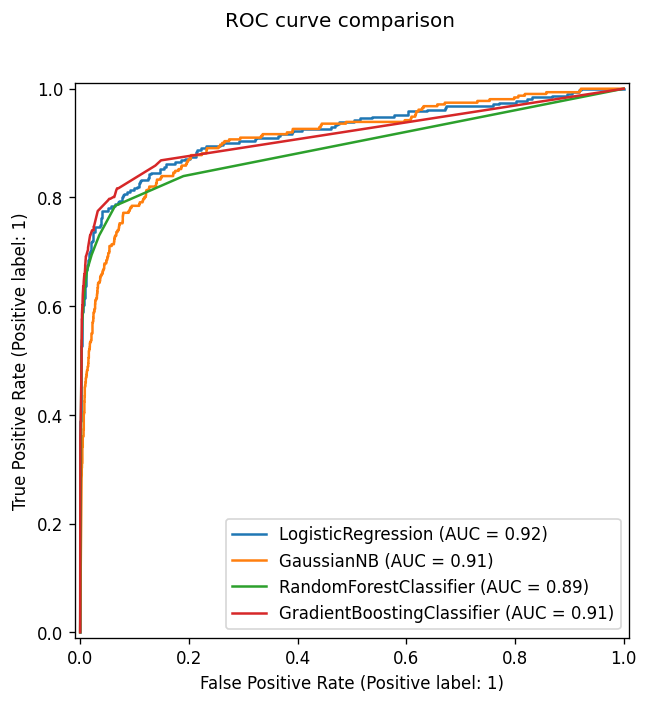

In [19]:
plt.figure(figsize=(8, 6), dpi=120)
ax = plt.gca()

for model in [logit, bayes, rf, gm]:
    
    # plot ROC curve
    tmp_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)

tmp_disp.figure_.suptitle("ROC curve comparison")
plt.show()

In [20]:
## Brier scores

for model in [logit, bayes, rf, gm]:
    probs = model.predict_proba(X_test)[:, 1]
    print(f'Brier score of {type(model).__name__}: {brier_score_loss(y_test, probs):.4f}')

Brier score of LogisticRegression: 0.0383
Brier score of GaussianNB: 0.1116
Brier score of RandomForestClassifier: 0.0398
Brier score of GradientBoostingClassifier: 0.0420


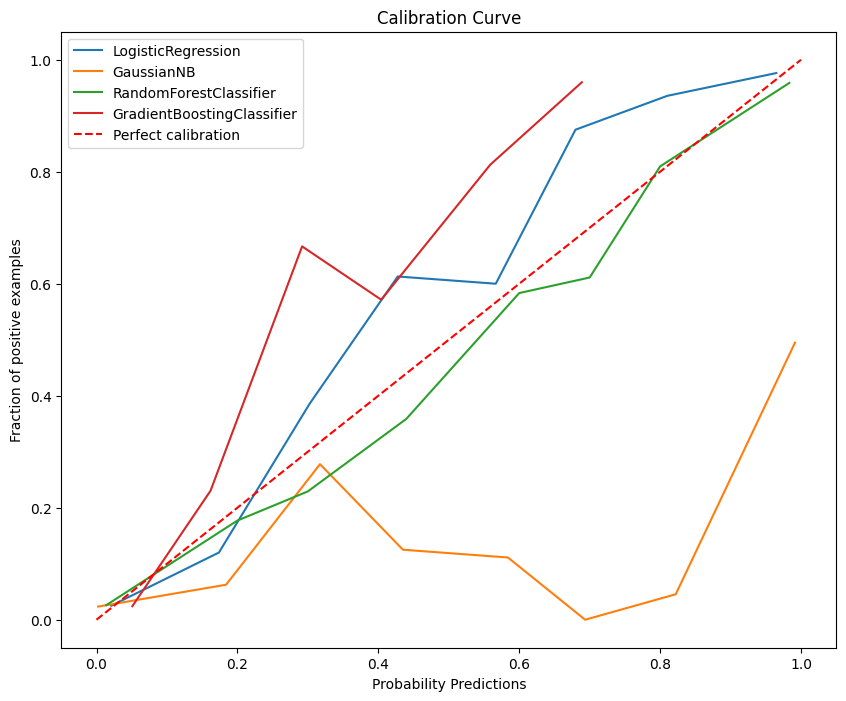

In [21]:
# calibration curve
plot_calibration_curve(bins=8)

We see that the models return not so well calibrated probabilities, apart from Random Forests. Remember however, that there are very few observations of the minority class (towards the right of the plot), to determine accurately the fraction of positives. So this calibration curve could be inaccurate.